###### Summary 
<font color=black size=3>
The main purpose of this project is that we want to figure out what features matter most in retail business and there is two parts of it:real retail shop and online retail.
In order to have a close look to real retail,We pick the dataset of Walmart sale forecasting.There are three csv :stores,features and sales.And train&test dataset is already offered.We also can make some prediction of week sales based on median of the weekly sales grouped by the Type of Store, Store & Department number, Month and Holiday dummy. 

In [1]:
import pandas as pd 
import numpy as np
from numpy import *
import gc
import time
import warnings
import os
from datetime import datetime
from datetime import timedelta
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import sparse
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
from keras import regularizers
from keras import optimizers
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


<font color=black size=3>Input the csv.The lable divide is to make sure which part of data is from test/train dataset.

In [2]:
features=pd.read_csv('Features data set.csv')
sales=pd.read_csv('sales data-set.csv')
stores=pd.read_csv('stores data-set.csv')
train1=pd.read_csv('train1.csv')
test1=pd.read_csv('test1.csv')
df=stores
df2=sales




<font color=black size=3>As a matter of fact,there are many factor effect on the retail sale.I have collected many features like CPI,ISHLIDAY and Emloyee rate.To have further reaserch,Let's use merge function to create a join of all three data sets.

In [3]:
train1['Divide'] = 'Value_Train'
test1['Divide'] = 'Value_test'
length_train = len(train1) # Count how many train data we have
df = pd.concat([train1,test1],axis=0) # Merge the two dataset into one


<font color=black size=3>MarkDown1-5 is anonymized data that is related to promotional markdowns that Walmart is running and since we don't know what it is so let's drop it first.But if other features make little contribution to price forecasting,we should pick up MarkDowns again. 

In [4]:
df.head()

,Date,Dept,Divide,IsHoliday,Store,Weekly_Sales
0,2010-02-05,1,Value_Train,False,1,24924.50
1,2010-02-12,1,Value_Train,True,1,46039.49
2,2010-02-19,1,Value_Train,False,1,41595.55
3,2010-02-26,1,Value_Train,False,1,19403.54
4,2010-03-05,1,Value_Train,False,1,21827.90


<font color=black size=3>Using the autocorrelation function caculate the correlation with diffrent features.First thing we know is that the weekly sales is mostly depend on size of the store.Dept also have some positive impact on sales.

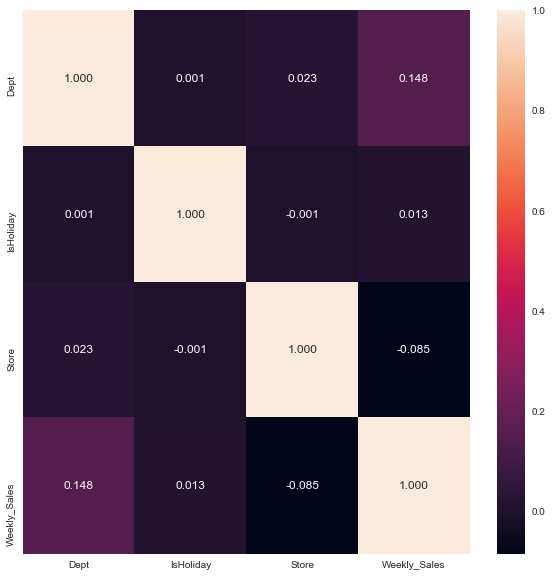

In [5]:
sns.set(style="white")
corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True, fmt=".3f",xticklabels=corr.columns.values,yticklabels=corr.columns.values)
plt.show()

<font color=black size=3>Except Week_Sales itself,actually stores is just the name of diffentrent shops.Besides,the impact of Is_holiday is not that obvious.Before creating the predict model,some pre-process is needed.

In [6]:
%matplotlib inline

In [7]:
df.loc[df['Weekly_Sales'] >300000]
df.loc[df['Weekly_Sales'] >240000,"Date"].value_counts()

2010-11-26    23
2011-11-25    22
2010-12-24    14
2011-12-23     9
2010-12-17     2
2010-02-05     1
2011-08-26     1
Name: Date, dtype: int64

In [8]:
df.fillna(0, inplace=True)

<font color=black size=3>Change the format of the value

In [9]:
#df['Type'] = 'Type_' + df['Type'].map(str)
df['Store'] = 'Store_' + df['Store'].map(str)
df['Dept'] = 'Dept_' + df['Dept'].map(str)
df['IsHoliday'] = 'IsHoliday_' + df['IsHoliday'].map(str)

In [10]:
#Convert categorical variable into dummy/indicator variables.type_dummies = pd.get_dummies(df['Type'])
store_dummies = pd.get_dummies(df['Store'])
dept_dummies = pd.get_dummies(df['Dept'])
holiday_dummies = pd.get_dummies(df['IsHoliday'])

<font color=black size=3>The value of time itself is string and it can't use directly since it makes no sense saying July make the price uprising.What we do here is to parse the date(String) to datetime and find the Promotion Holiday(black friday and christmas) in them,which may make contribution to price change.

In [11]:
df['DateType'] = [datetime.strptime(date,'%Y-%m-%d').date() for date in df['Date'].astype(str).values.tolist()]
df['Month'] = [date.month for date in df['DateType']]
df['Month'] = 'Month_' + df['Month'].map(str)
Month_dummies = pd.get_dummies(df['Month'] )

In [12]:
#Regular Expression.The code in the brackets after "where"is the group and "|" shows each specific string we want.
df['Black_Friday'] = np.where((df['DateType']==datetime(2010, 11, 26).date()) | (df['DateType']==datetime(2011, 11, 25).date()), 'yes', 'no')
df['Pre_christmas'] = np.where((df['DateType']==datetime(2010, 12, 23).date()) | (df['DateType']==datetime(2010, 12, 24).date()) | (df['DateType']==datetime(2011, 12, 23).date()) | (df['DateType']==datetime(2011, 12, 24).date()), 'yes', 'no')
df['Black_Friday'] = 'Black_Friday_' + df['Black_Friday'].map(str)
df['Pre_christmas'] = 'Pre_christmas_' + df['Pre_christmas'].map(str)
Black_Friday_dummies = pd.get_dummies(df['Black_Friday'] )
Pre_christmas_dummies = pd.get_dummies(df['Pre_christmas'] )

In [13]:
df = pd.concat([df,holiday_dummies,Pre_christmas_dummies,Black_Friday_dummies],axis=1)

<font color=black size=3>Caculate the average sale and create the medians column.

<font color=black size=3>

In [14]:
medians = pd.DataFrame({'The_Median' :df.loc[df['Divide']=='Value_Train'].groupby(by=['Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()
medians.head()

,Dept,Store,Month,IsHoliday,The_Median
0,Dept_1,Store_1,Month_1,IsHoliday_False,17350.585
1,Dept_1,Store_1,Month_10,IsHoliday_False,23388.030
2,Dept_1,Store_1,Month_11,IsHoliday_False,19551.115
3,Dept_1,Store_1,Month_11,IsHoliday_True,19865.770
4,Dept_1,Store_1,Month_12,IsHoliday_False,39109.390


In [15]:
df = df.merge(medians, how = 'outer', on = ['Dept','Store','Month','IsHoliday'])

In [16]:
df['The_Median'].fillna(df['The_Median'].loc[df['Divide']=='Value_Train'].median(), inplace=True) 
df['Key'] = df['Dept'].map(str)+df['Store'].map(str)+df['Date'].map(str)+df['IsHoliday'].map(str)


<font color=black size=3>As you can see in the following diagram,there boolean value "0" and "1" to show it is holiday or not and meadian value is added.

In [17]:
df.head()

,Date,Dept,Divide,IsHoliday,Store,Weekly_Sales,DateType,Month,Black_Friday,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,The_Median,Key
0,2010-02-05,Dept_1,Value_Train,IsHoliday_False,Store_1,24924.50,2010-02-05,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Dept_1Store_12010-02-05IsHoliday_False
1,2010-02-19,Dept_1,Value_Train,IsHoliday_False,Store_1,41595.55,2010-02-19,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Dept_1Store_12010-02-19IsHoliday_False
2,2010-02-26,Dept_1,Value_Train,IsHoliday_False,Store_1,19403.54,2010-02-26,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Dept_1Store_12010-02-26IsHoliday_False
3,2011-02-04,Dept_1,Value_Train,IsHoliday_False,Store_1,21665.76,2011-02-04,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Dept_1Store_12011-02-04IsHoliday_False
4,2011-02-18,Dept_1,Value_Train,IsHoliday_False,Store_1,46845.87,2011-02-18,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Dept_1Store_12011-02-18IsHoliday_False


<font color=black size=3>In some period of time we can take the sale as a continues data.So it is a little bit like LSTM that we decide to take the last week sale as one of the features.If the sales data is inaccessible the column will be filled with median data.

In [18]:
df['DateLagged'] = df['DateType']- timedelta(days=7)
df.head()

,Date,Dept,Divide,IsHoliday,Store,Weekly_Sales,DateType,Month,Black_Friday,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,The_Median,Key,DateLagged
0,2010-02-05,Dept_1,Value_Train,IsHoliday_False,Store_1,24924.50,2010-02-05,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Dept_1Store_12010-02-05IsHoliday_False,2010-01-29
1,2010-02-19,Dept_1,Value_Train,IsHoliday_False,Store_1,41595.55,2010-02-19,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Dept_1Store_12010-02-19IsHoliday_False,2010-02-12
2,2010-02-26,Dept_1,Value_Train,IsHoliday_False,Store_1,19403.54,2010-02-26,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Dept_1Store_12010-02-26IsHoliday_False,2010-02-19
3,2011-02-04,Dept_1,Value_Train,IsHoliday_False,Store_1,21665.76,2011-02-04,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Dept_1Store_12011-02-04IsHoliday_False,2011-01-28
4,2011-02-18,Dept_1,Value_Train,IsHoliday_False,Store_1,46845.87,2011-02-18,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Dept_1Store_12011-02-18IsHoliday_False,2011-02-11


In [19]:
sorted_df = df.sort_values(['Store', 'Dept','DateType'], ascending=[1, 1,1])
sorted_df = sorted_df.reset_index(drop=True)

<font color=black size=3>Sorting makes lagge process easy and the following loop is to set the laggedSales value.The percentage shows how much progress we have made.

In [20]:
sorted_df['LaggedSales'] = np.nan
sorted_df['LaggedAvailable'] = np.nan 
last=df.loc[0] 
row_len = sorted_df.shape[0]
for index, row in sorted_df.iterrows():
    lag_date = row["DateLagged"]
    if((last['DateType']== lag_date) & (last['Weekly_Sales']>0)): 
        sorted_df.set_value(index, 'LaggedSales',last['Weekly_Sales'])
        sorted_df.set_value(index, 'LaggedAvailable',1)
    else:
        sorted_df.set_value(index, 'LaggedSales',row['The_Median'])
        sorted_df.set_value(index, 'LaggedAvailable',0)

    last = row 
    if(index%int(row_len/10)==0): 
        print(str(int(index*100/row_len))+'% loaded')

0% loaded
9% loaded
19% loaded
29% loaded
39% loaded
49% loaded
59% loaded
69% loaded
79% loaded
89% loaded
99% loaded


In [21]:
sorted_df[['Dept', 'Store','DateType','LaggedSales','Weekly_Sales','The_Median']].head()

,Dept,Store,DateType,LaggedSales,Weekly_Sales,The_Median
0,Dept_1,Store_1,2010-02-05,23510.49,24924.50,23510.49
1,Dept_1,Store_1,2010-02-12,24924.50,46039.49,37887.17
2,Dept_1,Store_1,2010-02-19,46039.49,41595.55,23510.49
3,Dept_1,Store_1,2010-02-26,41595.55,19403.54,23510.49
4,Dept_1,Store_1,2010-03-05,19403.54,21827.90,21280.40


<font color=black size=3>Take the risk of losing data,we use inner join here.The table created is the sales infromation in different dates for one department in one shop.

In [22]:
df = df.merge(sorted_df[['Dept', 'Store','DateType','LaggedSales','LaggedAvailable']], how = 'inner', on = ['Dept', 'Store','DateType'])

In [23]:
df['Sales_dif'] = df['The_Median'] - df['LaggedSales']
df[['Dept', 'Store','DateType','LaggedSales','Weekly_Sales','The_Median']].head()

,Dept,Store,DateType,LaggedSales,Weekly_Sales,The_Median
0,Dept_1,Store_1,2010-02-05,23510.49,24924.50,23510.49
1,Dept_1,Store_1,2010-02-19,46039.49,41595.55,23510.49
2,Dept_1,Store_1,2010-02-26,41595.55,19403.54,23510.49
3,Dept_1,Store_1,2011-02-04,18461.18,21665.76,23510.49
4,Dept_1,Store_1,2011-02-18,37887.17,46845.87,23510.49


In [24]:
 df_backup = df

In [25]:
df['Disparity'] = df['The_Median'] - df['Weekly_Sales']

<font color=black size=3>We just add some new features and let's call the correlate funcation and take all features into it.

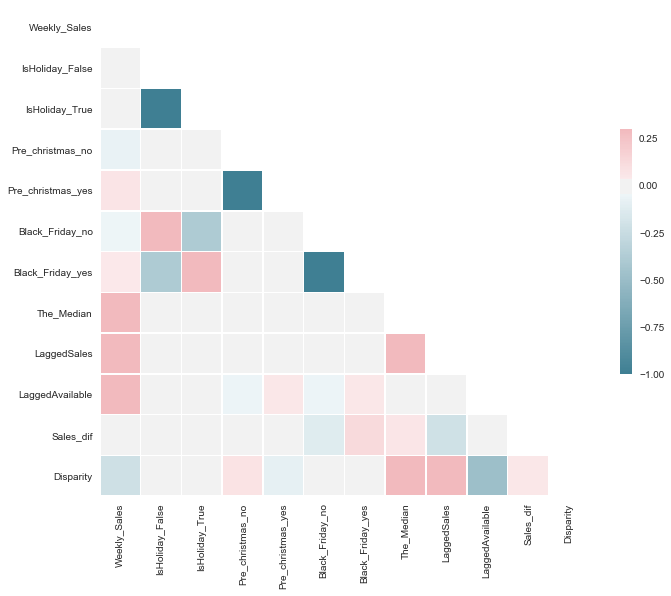

In [26]:
# This part of code is from https://www.kaggle.com/codemonkeyhq/forecasting-challenge/edit
sns.set(style="white")
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f,ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

<font color=black size=3>Obviously the new column we just added like median an lagged sales do play a role in sale change.There is another problem that features csv contains null and since we use join our dataframe there are many null value here.In order to make it up,md_present is added.

In [27]:
df2=pd.merge(sales,features, on=['Store','Date', 'IsHoliday'], how='left')
df2=pd.merge(df2,stores, on=['Store'], how='left')
df2['Store'] = 'Store_' + df2['Store'].map(str)
df2['DateType'] = [datetime.strptime(date,'%d/%m/%Y').date() for date in df2['Date'].astype(str).values.tolist()]
df2=pd.merge(df,df2, on=['Store','DateType','Weekly_Sales'], how='left')
df2 = df2.assign(md1_present = df2.MarkDown1.notnull())
df2 = df2.assign(md2_present = df2.MarkDown2.notnull())
df2 = df2.assign(md3_present = df2.MarkDown3.notnull())
df2 = df2.assign(md4_present = df2.MarkDown4.notnull())
df2 = df2.assign(md5_present = df2.MarkDown5.notnull())
df=df2


<font color=black size=3>Our pre-process is done.Now we need to review what input features we gonna use and use and group them together.It will be easy to pick up all input features using the selector we make.

In [28]:
selector = [
    'CPI',
    'Fuel_Price',
    'MarkDown1',
    'MarkDown2',
    'MarkDown3',
    'MarkDown4',
    'MarkDown5',
    'Size',
    'Temperature',
    'Unemployment',
    'md1_present',
    'md2_present',
    'md3_present',
    'md4_present',
    'md5_present',

    'IsHoliday_False',
    'IsHoliday_True',
    'Pre_christmas_no',
    'Pre_christmas_yes',
    'Black_Friday_no',
    'Black_Friday_yes',    
    'LaggedSales',
    'Sales_dif',
    'LaggedAvailable'
    ]
display(df2[selector].describe())
display(df2[selector].head())

,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,Unemployment,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
count,421764.000000,421764.000000,150749.000000,111284.000000,137139.000000,134993.000000,151502.000000,421764.000000,421764.000000,421764.000000,536828.000000,536828.000000,536828.000000,536828.000000,536828.000000,536828.000000,536828.000000,536828.000000,536828.000000
mean,171.195517,3.361063,7244.567761,3333.768017,1438.924118,3382.902156,4627.578656,136698.996747,60.092726,7.960640,0.928102,0.071898,0.988851,0.011149,0.988896,0.011104,15964.058862,-195.290213,0.773389
std,39.159706,0.458541,8291.024935,9473.963908,9621.430759,6291.928123,5961.909993,60992.346096,18.448236,1.863546,0.258320,0.258320,0.104998,0.104998,0.104789,0.104789,22687.264573,6002.468724,0.418639
min,126.064000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,34875.000000,-2.060000,3.879000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1750.000000,-540263.085000,0.000000
25%,132.022667,2.933000,2232.080000,41.600000,5.080000,504.220000,1878.440000,93638.000000,46.700000,6.891000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2098.810000,-301.891250,1.000000
50%,182.318780,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.100000,140167.000000,62.090000,7.866000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,7602.980000,0.000000,1.000000
75%,212.416993,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5556.150000,202505.000000,74.280000,8.572000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,20174.890000,279.491250,1.000000
max,227.232807,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,219622.000000,100.140000,14.313000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,693099.360000,579251.325000,1.000000


,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,Unemployment,...,md5_present,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
0,211.096358,2.572,NaN,NaN,NaN,NaN,NaN,151315.0,42.31,8.106,...,False,1,0,1,0,1,0,23510.49,0.00,0.0
1,211.289143,2.514,NaN,NaN,NaN,NaN,NaN,151315.0,39.93,8.106,...,False,1,0,1,0,1,0,46039.49,-22529.00,1.0
2,211.319643,2.561,NaN,NaN,NaN,NaN,NaN,151315.0,46.63,8.106,...,False,1,0,1,0,1,0,41595.55,-18085.06,1.0
3,212.566881,2.989,NaN,NaN,NaN,NaN,NaN,151315.0,42.27,7.742,...,False,1,0,1,0,1,0,18461.18,5049.31,1.0
4,213.247885,3.045,NaN,NaN,NaN,NaN,NaN,151315.0,57.36,7.742,...,False,1,0,1,0,1,0,37887.17,-14376.68,1.0


<font color=black size=3>As we have merged the train and test dataset together,it's time to split it.

In [29]:
train = df2.loc[df2['Divide']=='Value_Train']
test = df2.loc[df2['Divide']=='Value_test']
test

,Date_x,Dept_x,Divide,IsHoliday_x,Store,Weekly_Sales,DateType,Month,Black_Friday,Pre_christmas,...,MarkDown5,CPI,Unemployment,Type,Size,md1_present,md2_present,md3_present,md4_present,md5_present
9,2013-02-01,Dept_1,Value_test,IsHoliday_False,Store_1,0.0,2013-02-01,Month_2,Black_Friday_no,Pre_christmas_no,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
10,2013-02-15,Dept_1,Value_test,IsHoliday_False,Store_1,0.0,2013-02-15,Month_2,Black_Friday_no,Pre_christmas_no,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
11,2013-02-22,Dept_1,Value_test,IsHoliday_False,Store_1,0.0,2013-02-22,Month_2,Black_Friday_no,Pre_christmas_no,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
15,2013-02-08,Dept_1,Value_test,IsHoliday_True,Store_1,0.0,2013-02-08,Month_2,Black_Friday_no,Pre_christmas_no,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
29,2013-03-01,Dept_1,Value_test,IsHoliday_False,Store_1,0.0,2013-03-01,Month_3,Black_Friday_no,Pre_christmas_no,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
30,2013-03-08,Dept_1,Value_test,IsHoliday_False,Store_1,0.0,2013-03-08,Month_3,Black_Friday_no,Pre_christmas_no,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
31,2013-03-15,Dept_1,Value_test,IsHoliday_False,Store_1,0.0,2013-03-15,Month_3,Black_Friday_no,Pre_christmas_no,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
32,2013-03-22,Dept_1,Value_test,IsHoliday_False,Store_1,0.0,2013-03-22,Month_3,Black_Friday_no,Pre_christmas_no,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
33,2013-03-29,Dept_1,Value_test,IsHoliday_False,Store_1,0.0,2013-03-29,Month_3,Black_Friday_no,Pre_christmas_no,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
48,2013-04-05,Dept_1,Value_test,IsHoliday_False,Store_1,0.0,2013-04-05,Month_4,Black_Friday_no,Pre_christmas_no,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False


<font color=black size=3>Unluckly this test file can't provide sale infromation which means we can not "test" the output of out model.The solution here is to regard 20% of train data as development(test).

In [30]:
np.random.seed(42)
X_train, X_dev, y_train, y_dev = train_test_split(train[selector], train['Disparity'], test_size=0.2, random_state=42)
X_train=X_train.fillna(0)
X_dev=X_dev.fillna(0)
y_train=y_train.fillna(0)
y_dev=y_dev.fillna(0)


<font color=black size=2>We choose to pick radomforest method here.We set the number of trees in the forest 20,"mse" means the function to measure the quality of a split,while None is set then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.min_samples_leaf shows The minimum number of samples required to be at a leaf node.max_leaf_nodesis the  grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity.we set None here then we have unlimited number of leaf nodes.bootstrap is a boolean value:Whether bootstrap samples are used when building trees.oob_score is whether to use out-of-bag samples to estimate the R^2 on unseen data,meanwhile false is the default value.n_jobs is a integer number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores.Random_state is also an integer shows RandomState instance or None, optional (default=None)If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.verbose is used to controls the verbosity of the tree building process.

#This part is from radomForest documentation 


In [31]:
#A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples
#of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample 
#size is always the same as the original input sample size but the samples are drawn with replacement if 
#bootstrap=True (default).

regr = RandomForestRegressor(n_estimators=20, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=2, warm_start=False)

#Train on data
regr.fit(X_train, y_train.ravel())

building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

In [32]:
y_pred_random = regr.predict(X_dev)

y_dev = y_dev.to_frame()

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished


<font color=black size=3>What we do here is transfroming the trendcy into numbers:if price is going up then the direction is 1 else it is 0.Then just like correlation heatmap random forest confusion matrix is shown.Y is the catagory from the data(y developing value from train set) and X is the predicted value.

In [33]:
def binary(input_data):
    direction = np.empty(input_data.shape[0])
    for i in range(input_data.shape[0]):
        if input_data[i] > 0:
            direction[i] = 1
        else:
            direction[i]= 0
    return direction


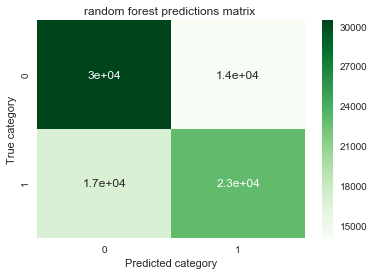

In [34]:
direction_true1= binary(y_dev.values)
direction_predict = binary(y_pred_random)

#shows the random forest confusion matrix 
cnf_matrix = confusion_matrix(direction_true1, direction_predict)
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
plt.title('random forest predictions matrix ')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show();

In [35]:
y_dev['Predicted'] = y_pred_random
df_out = pd.merge(train,y_dev[['Predicted']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_out = df_out[~pd.isnull(df_out['Predicted'])]
df_out.head()

,Date_x,Dept_x,Divide,IsHoliday_x,Store,Weekly_Sales,DateType,Month,Black_Friday,Pre_christmas,...,CPI,Unemployment,Type,Size,md1_present,md2_present,md3_present,md4_present,md5_present,Predicted
2,2010-02-26,Dept_1,Value_Train,IsHoliday_False,Store_1,19403.54,2010-02-26,Month_2,Black_Friday_no,Pre_christmas_no,...,211.319643,8.106,A,151315.0,False,False,False,False,False,-5600.73275
7,2012-02-17,Dept_1,Value_Train,IsHoliday_False,Store_1,54060.10,2012-02-17,Month_2,Black_Friday_no,Pre_christmas_no,...,220.425759,7.348,A,151315.0,True,True,True,True,True,-13351.51275
14,2012-02-10,Dept_1,Value_Train,IsHoliday_True,Store_1,36988.49,2012-02-10,Month_2,Black_Friday_no,Pre_christmas_no,...,220.265178,7.348,A,151315.0,True,True,True,True,True,1381.56675
28,2012-03-30,Dept_1,Value_Train,IsHoliday_False,Store_1,28952.86,2012-03-30,Month_3,Black_Friday_no,Pre_christmas_no,...,221.361012,7.348,A,151315.0,True,True,True,True,True,-339.45500
39,2011-04-01,Dept_1,Value_Train,IsHoliday_False,Store_1,20398.09,2011-04-01,Month_4,Black_Friday_no,Pre_christmas_no,...,214.837166,7.682,A,151315.0,False,False,False,False,False,666.95175


<font color=black size=3>Plotting is the best way to show distribution of data."Predicted" is the column based on the direction we made and the prediction depends on both of median value of sale and "predictd". 

In [36]:
def plot_prediction(predicted,true,desciption):
    fig, ax = plt.subplots()
    ax.scatter(true, predicted, edgecolors=(0, 0, 0))
    ax.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted by '+desciption)
    ax.plot([-30,30], [0,0], 'k-')   
    ax.plot([0,0], [-30,30], 'k-')
    plt.show()

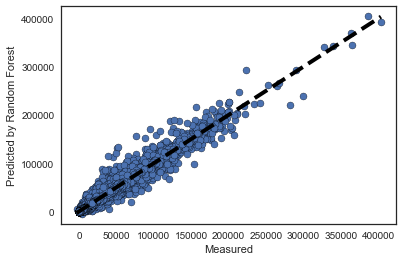

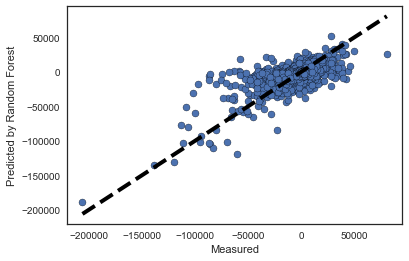

In [37]:
df_out['prediction'] = df_out['The_Median']-df_out['Predicted']
plot_prediction(df_out['Weekly_Sales'],df_out['prediction'],"Random Forest")
plot_prediction(y_pred_random,y_dev['Disparity'].values,"Random Forest")

<font color=black size=3>Belowing we should how the random forest model fitting the train(developing)data set and After debuging ,the function works well and we gonna feed it with test file.

In [38]:
rf_model = RandomForestRegressor(n_estimators=80, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=0, warm_start=False)


#Train on data
train=train.fillna(0)
rf_model.fit(train[selector], train['Disparity'])


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
test=test.fillna(0)
final_y_prediction = rf_model.predict(test[selector])

In [40]:
testfile = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile['prediction'] = testfile['The_Median']-testfile[0]
testfile.head()

,Date_x,Dept_x,Divide,IsHoliday_x,Store,Weekly_Sales,DateType,Month,Black_Friday,Pre_christmas,...,Unemployment,Type,Size,md1_present,md2_present,md3_present,md4_present,md5_present,0,prediction
0,2013-02-01,Dept_1,Value_test,IsHoliday_False,Store_1,0.0,2013-02-01,Month_2,Black_Friday_no,Pre_christmas_no,...,0.0,0,0.0,False,False,False,False,False,798.707750,22711.782250
1,2013-02-15,Dept_1,Value_test,IsHoliday_False,Store_1,0.0,2013-02-15,Month_2,Black_Friday_no,Pre_christmas_no,...,0.0,0,0.0,False,False,False,False,False,798.707750,22711.782250
2,2013-02-22,Dept_1,Value_test,IsHoliday_False,Store_1,0.0,2013-02-22,Month_2,Black_Friday_no,Pre_christmas_no,...,0.0,0,0.0,False,False,False,False,False,798.707750,22711.782250
3,2013-02-08,Dept_1,Value_test,IsHoliday_True,Store_1,0.0,2013-02-08,Month_2,Black_Friday_no,Pre_christmas_no,...,0.0,0,0.0,False,False,False,False,False,-2744.855063,40632.025062
4,2013-03-01,Dept_1,Value_test,IsHoliday_False,Store_1,0.0,2013-03-01,Month_3,Black_Friday_no,Pre_christmas_no,...,0.0,0,0.0,False,False,False,False,False,730.383250,20550.016750


<font color=black size=3>Here is the head of prediction dataframe.

In [41]:
predict_result = pd.DataFrame({'store_dept_date':pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Store']]).map(str) + '_' +
                           pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Dept_x']]).map(str)  + '_' +
                           testfile['Date_x'].map(str),
                          'Weekly_Sales':testfile['prediction']})
predict_result.head()

,Weekly_Sales,store_dept_date
0,22711.782250,1_1_2013-02-01
1,22711.782250,1_1_2013-02-15
2,22711.782250,1_1_2013-02-22
3,40632.025062,1_1_2013-02-08
4,20550.016750,1_1_2013-03-01


<font color=black size=3>In a word,the retail sale is up rising but none features shows strong power to really make a difference.Basically,the prediction is made on derived properties of sale of week itself.

<font color=black size=2>
Reference


1.https://keras.io/activations/                                           
2.https://github.com/davidthaler/Walmart_competition_code                              
3.https://github.com/threecourse/kaggle-walmart-recruiting-sales-in-stormy-weather             
4.https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd               
5.https://www.kaggle.com/codemonkeyhq/cracking-the-walmart-sales-forecasting-challenge/edit             
6.http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html